# 建立客戶流失預測模型

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
sns.set_style("darkgrid")

import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('./XGboost_archive'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./XGboost_archive/coupon_redempt.csv
./XGboost_archive/hh_demographic.csv
./XGboost_archive/transaction_data.csv
./XGboost_archive/product.csv
./XGboost_archive/coupon.csv
./XGboost_archive/causal_data.csv
./XGboost_archive/campaign_table.csv
./XGboost_archive/campaign_desc.csv


# 廣告活動說明

In [4]:
dfs = dict()
dfs["campaign_desc"] = pd.read_csv("./XGboost_archive/campaign_desc.csv")
dfs["campaign_desc"].head()

,DESCRIPTION,CAMPAIGN,START_DAY,END_DAY
0,TypeB,24,659,719
1,TypeC,15,547,708
2,TypeB,25,659,691
3,TypeC,20,615,685
4,TypeB,23,646,684


# 每個活動持續時間

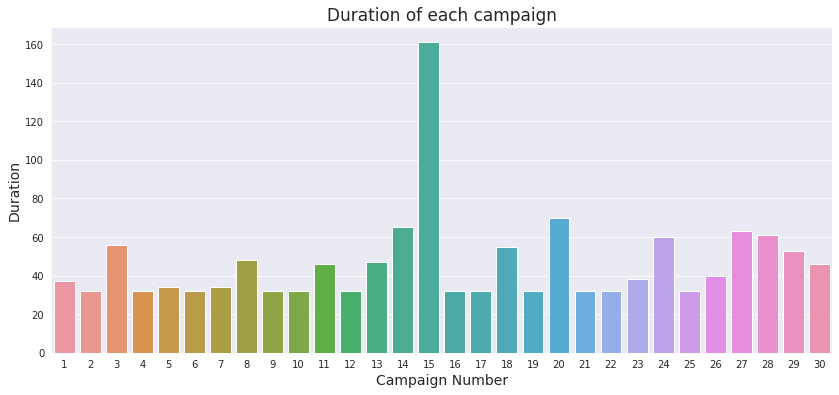

In [5]:
dfs["campaign_desc"]["DUR"] = dfs["campaign_desc"].END_DAY-dfs["campaign_desc"].START_DAY
fig = plt.figure(figsize=(14,6))
sns.barplot(x="CAMPAIGN",y="DUR",data=dfs["campaign_desc"],orient="v",
            order=dfs["campaign_desc"].sort_values(by="CAMPAIGN").CAMPAIGN.values)
plt.title('Duration of each campaign', fontsize=17)
plt.xlabel('Campaign Number', fontsize=14)
plt.ylabel('Duration', fontsize=14)
plt.show()

# 廣告活動數據集

In [6]:
dfs["campaign_table"] = pd.read_csv("./XGboost_archive/campaign_table.csv")
dfs["campaign_table"].head()

,DESCRIPTION,household_key,CAMPAIGN
0,TypeA,17,26
1,TypeA,27,26
2,TypeA,212,26
3,TypeA,208,26
4,TypeA,192,26


In [7]:
total_households = 2500
len(dfs["campaign_table"].household_key.unique())

1584

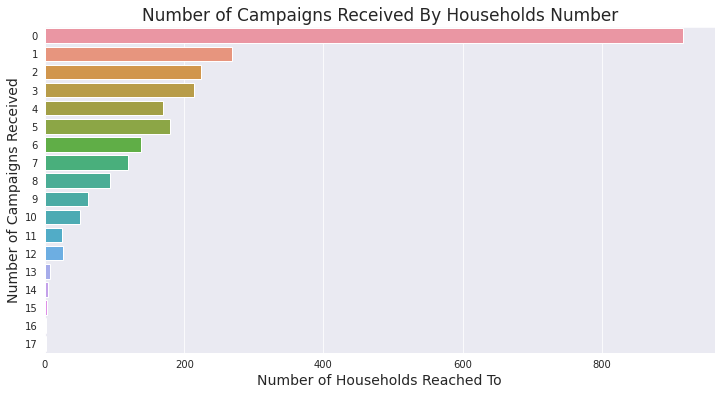

In [8]:
no_of_received_campaigns_per_house = dfs["campaign_table"].household_key.value_counts()
no_of_received_campaigns = no_of_received_campaigns_per_house.value_counts()
no_of_received_campaigns[0] = total_households-len(no_of_received_campaigns_per_house)
no_of_received_campaigns = pd.DataFrame(list(zip(no_of_received_campaigns.index,no_of_received_campaigns))
                                        ,columns=["Number of Campaigns Received",
                                                  "Number of Households Reached To"]).sort_values(
                                                                                            by="Number of Campaigns Received",ascending=True)
plt.figure(figsize=(12,6))
sns.barplot(y="Number of Campaigns Received",x="Number of Households Reached To",data=no_of_received_campaigns,orient="h",order=no_of_received_campaigns["Number of Campaigns Received"])
plt.title('Number of Campaigns Received By Households Number', fontsize=17)
plt.xlabel('Number of Households Reached To', fontsize=14)
plt.ylabel('Number of Campaigns Received', fontsize=14)
plt.show()

# 活動的頻率

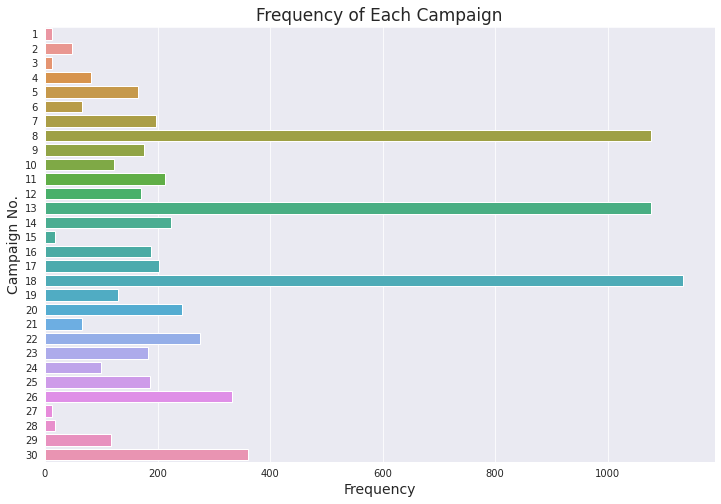

In [9]:
freq_campaigns = pd.DataFrame(list(zip(dfs["campaign_table"].CAMPAIGN.value_counts().index, 
                                       dfs["campaign_table"].CAMPAIGN.value_counts())),columns=["Campaign","Frequency"])
fig = plt.figure(figsize=(12,8))
sns.barplot(y="Campaign",x="Frequency",data = freq_campaigns,orient="h")
plt.title('Frequency of Each Campaign', fontsize=17)
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Campaign No.', fontsize=14)
plt.show()

# 優惠券

In [10]:
dfs["coupon"] = pd.read_csv("./XGboost_archive/coupon.csv")
dfs["coupon"].head()

,COUPON_UPC,PRODUCT_ID,CAMPAIGN
0,10000089061,27160,4
1,10000089064,27754,9
2,10000089073,28897,12
3,51800009050,28919,28
4,52100000076,28929,25


# 優惠券兌換

In [11]:
dfs["coupon_redempt"] = pd.read_csv("./XGboost_archive/coupon_redempt.csv")
dfs["coupon_redempt"].head()

,household_key,DAY,COUPON_UPC,CAMPAIGN
0,1,421,10000085364,8
1,1,421,51700010076,8
2,1,427,54200000033,8
3,1,597,10000085476,18
4,1,597,54200029176,18


In [12]:
len(dfs["coupon_redempt"].household_key.unique())

434

# 每個廣告活動的兌換數量

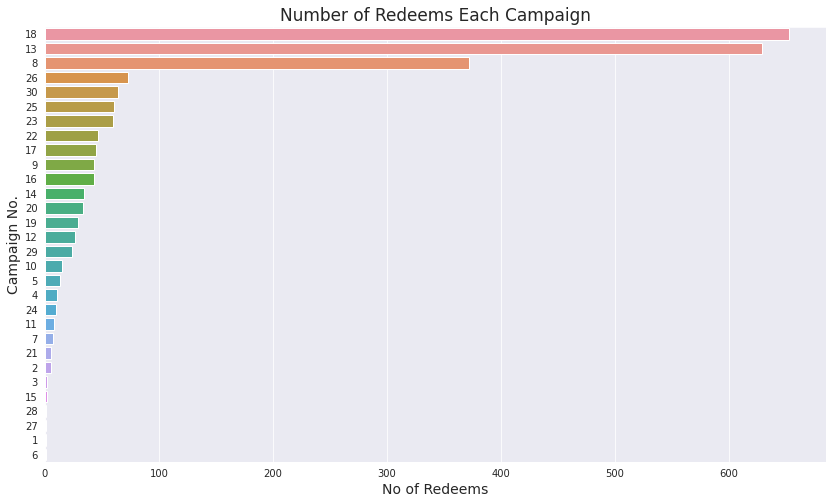

In [13]:
redeem_frequency = pd.DataFrame(list(zip(dfs["coupon_redempt"].CAMPAIGN.value_counts().index, dfs["coupon_redempt"].CAMPAIGN.value_counts())),columns=["Campaign","No of Redeems"])
fig = plt.figure(figsize=(14,8))
sns.barplot(y="Campaign",x="No of Redeems",data = redeem_frequency,orient="h",order=redeem_frequency.Campaign)
plt.title('Number of Redeems Each Campaign', fontsize=17)
plt.xlabel('No of Redeems', fontsize=14)
plt.ylabel('Campaign No.', fontsize=14)
plt.show()

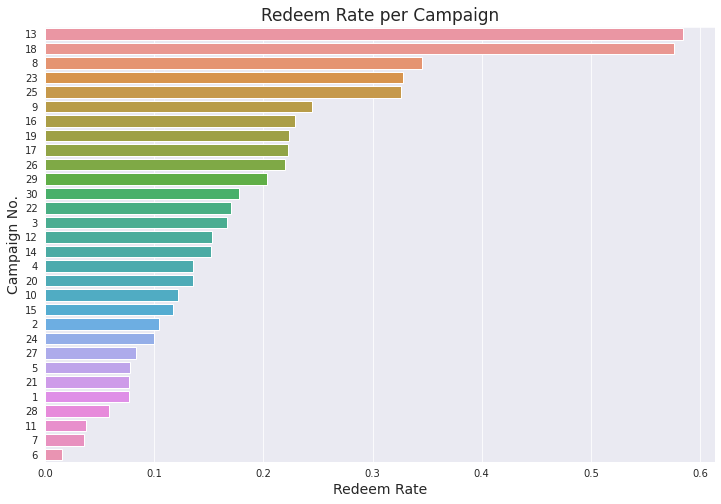

In [14]:
redems_per_camp = dfs["coupon_redempt"].CAMPAIGN.value_counts().sort_values()/dfs["campaign_table"].CAMPAIGN.value_counts().sort_values()
redems_per_camp = pd.DataFrame(list(zip(redems_per_camp.index,redems_per_camp)),
                               columns=["Campaign","Redeem_Rate"]).sort_values(by="Redeem_Rate",ascending=False)
plt.figure(figsize=(12,8))
sns.barplot(y="Campaign",x="Redeem_Rate",data=redems_per_camp,orient="h",order=redems_per_camp.Campaign)
plt.title('Redeem Rate per Campaign', fontsize=17)
plt.xlabel('Redeem Rate', fontsize=14)
plt.ylabel('Campaign No.', fontsize=14)
plt.show()

# 交易數據

In [15]:
dfs["transaction_data"] = pd.read_csv("./XGboost_archive/transaction_data.csv")
dfs["transaction_data"].head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


# 對交易數據進行一些描述性分析。先按住戶號碼對數據進行分組

In [16]:
grouped_sum = dfs["transaction_data"].groupby("household_key").sum()

# 這是兩年內一個家庭的平均購買量

In [17]:
av_purc = round(dfs['transaction_data'].SALES_VALUE.sum()/len(grouped_sum),1)
av_purc

3223.0

<!-- # 一個家庭在兩年內購買的平均產品總數 -->

In [18]:
av_tot_prod = round(grouped_sum["QUANTITY"].mean(),1)
av_tot_prod

104274.2

# 一個家庭在兩年內購買的特殊產品的平均總數

In [19]:
av_uniq_prod = round(len(dfs["transaction_data"].groupby(["household_key","PRODUCT_ID"]).sum()["QUANTITY"])/len(grouped_sum),1)
av_uniq_prod

560.6

# 兩年內每個家庭的到店的平均次數

In [20]:
av_days_visited = round(len(dfs["transaction_data"].groupby(["household_key","DAY"]).count())/len(grouped_sum),1)
av_days_visited

90.2

# 熱門商店

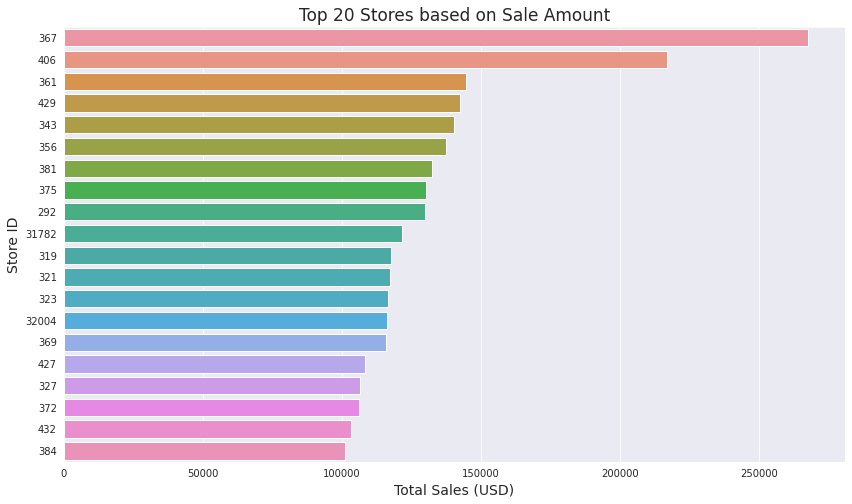

In [21]:
sales_per_store = dfs["transaction_data"].groupby("STORE_ID").sum()["SALES_VALUE"].sort_values(ascending=False)
sales_per_store = pd.DataFrame(list(zip(sales_per_store.index,sales_per_store)),columns=["Store ID","Total Sales (USD)"])
fig_store = plt.figure(figsize=(14,8))
sns.barplot(y="Store ID",x="Total Sales (USD)",data = sales_per_store[:20],order=sales_per_store[:20]["Store ID"],orient="h")
plt.title('Top 20 Stores based on Sale Amount', fontsize=17)
plt.xlabel('Total Sales (USD)', fontsize=14)
plt.ylabel('Store ID', fontsize=14)
plt.show()

# 消費排名前２０的顧客

總購買金額最多客戶的ID為1023，他在2500家庭中以接近40,000美元的消費總額成為第一

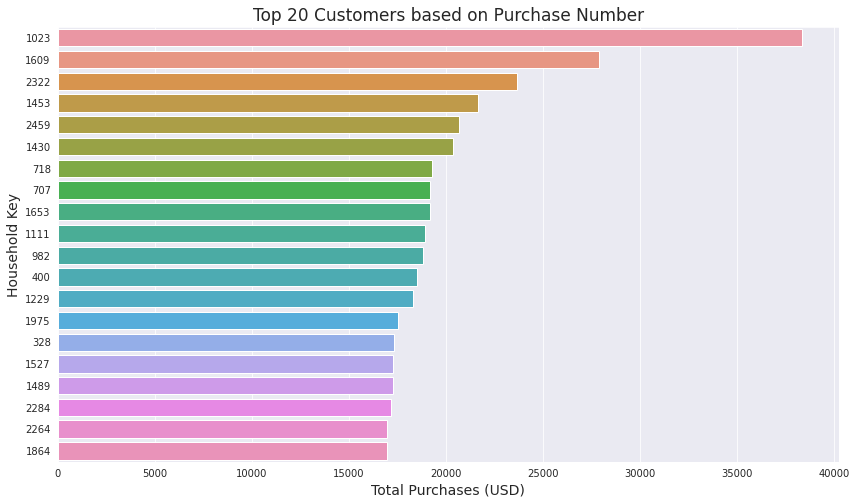

In [22]:
purc_per_cust = dfs["transaction_data"].groupby("household_key").sum()["SALES_VALUE"].sort_values(ascending=False)
purc_per_cust = pd.DataFrame(list(zip(purc_per_cust.index,purc_per_cust)),columns=["household_key","Total Purchase (USD)"])
fig_store = plt.figure(figsize=(14,8))
sns.barplot(y="household_key",x="Total Purchase (USD)",data = purc_per_cust[:20],order=purc_per_cust[:20]["household_key"],orient="h")
plt.title('Top 20 Customers based on Purchase Number', fontsize=17)
plt.xlabel('Total Purchases (USD)', fontsize=14)
plt.ylabel('Household Key', fontsize=14)
plt.show()

# 人口統計數據

In [23]:
dfs["hh_demographic"] = pd.read_csv("./XGboost_archive/hh_demographic.csv")
dfs["hh_demographic"].head()

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16


# 　　定義用於人口統計學變量探索性分析

In [24]:
def pie_categorical(data):
    #function to plot the histogram of categorical variables in pie graph
    features = data.columns
    #plot pie charts of categorical variables
    fig_pie_cat = plt.figure(figsize=(15,15))
    count = 1
    #calculate dynamic numbers of subplot rows and columns
    cols = int(np.ceil(np.sqrt(len(features))))
    rows = int(np.ceil(len(features)/cols))
    for i in features:
        ax = fig_pie_cat.add_subplot(rows,cols,count)
        data[i].value_counts().plot(kind="pie",autopct="%.1f%%",ax=ax)
        plt.ylabel("")
        plt.title(i,fontweight="bold",fontsize=8)
        count += 1

def hist_numeric(data):
    #function to plot the histogram of numeric variables
    features = data.columns
    fig_hists = plt.figure(figsize=(15,15))
    fig_hists.subplots_adjust(hspace=0.5,wspace=0.5)
    count = 1
    #calculate dynamic numbers of subplot rows and columns
    cols = int(np.ceil(np.sqrt(len(features))))
    rows = int(np.ceil(len(features)/cols))
    for i in features:
        ax = fig_hists.add_subplot(rows,cols,count)
        data[i].plot(kind="hist",alpha=.5,bins=25,edgecolor="navy",legend=False,ax=ax)
        ax.set_xlabel("")
        ax.set_title(i,fontweight="bold",fontsize=10)
        count += 1

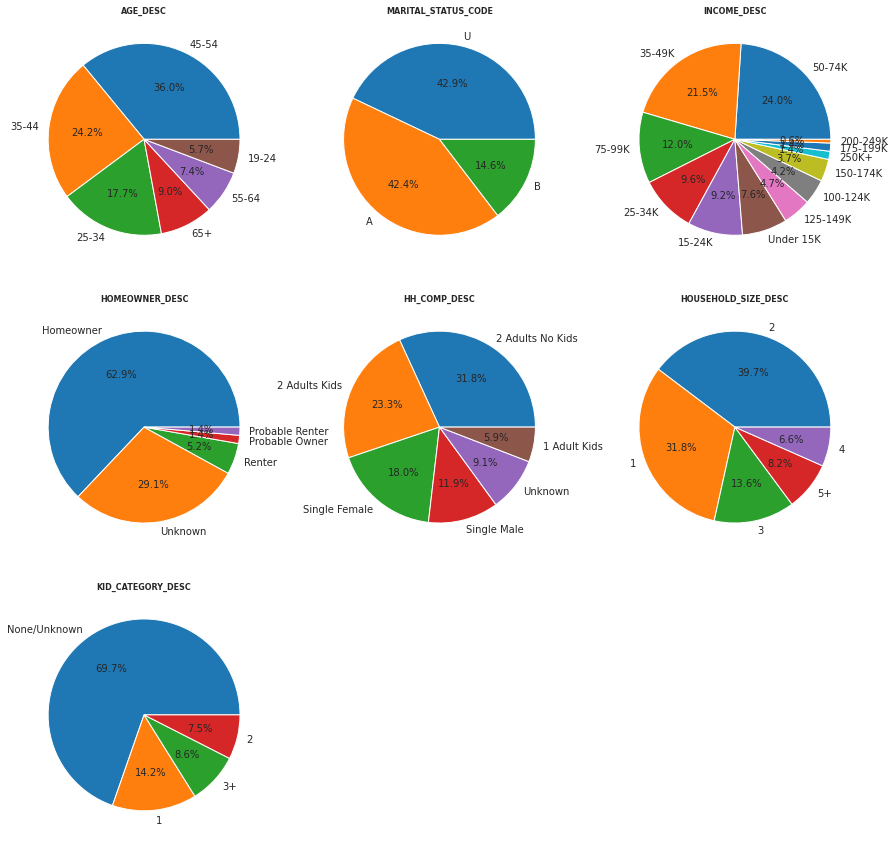

In [25]:
pie_categorical(dfs["hh_demographic"].drop("household_key",axis=1))

# 　流失預測

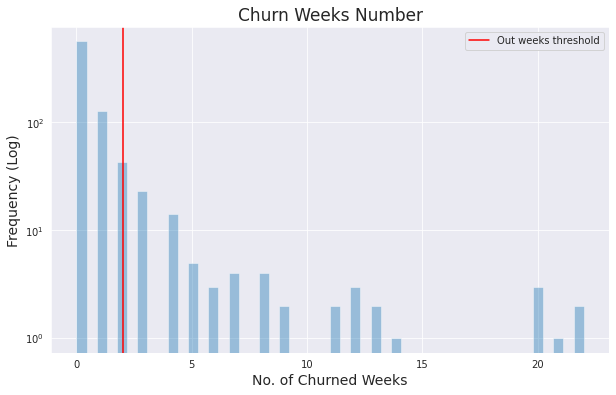

In [26]:
out_weeks_threshold = 2

#weekly customer purchase amount
weekly_purchase = dfs["transaction_data"].groupby(["household_key","WEEK_NO"]).sum()["SALES_VALUE"]
weekly_purchase = weekly_purchase.unstack()

#customer churned by their last 2 week's purchasing behaviour
#go through all households and calculate out weeks
target = []
common_houses = set(dfs["hh_demographic"].household_key) & set(dfs["transaction_data"].household_key)
for house in common_houses:
  target.append(102-weekly_purchase.loc[house].dropna().index[-1])

target = pd.DataFrame(list(zip(common_houses,target)),columns=["household_key","No. of Churned Weeks"])
plt.figure(figsize=(10,6))
ax = sns.distplot(target["No. of Churned Weeks"],kde=False)
ax.axvline(x=out_weeks_threshold,c="red",label="Out weeks threshold")
ax.legend()
ax.set_yscale("log")
ax.set_ylabel("Frequency (Log)", fontsize=14)
ax.set_xlabel("No. of Churned Weeks", fontsize=14)

plt.title('Churn Weeks Number', fontsize=17)
# plt.xlabel('Total Purchases (USD)', fontsize=14)
# plt.ylabel('Household Key', fontsize=14)
plt.show()

In [27]:
target["isChurned"] = target["No. of Churned Weeks"]>=out_weeks_threshold
target.drop("No. of Churned Weeks",axis=1,inplace=True)

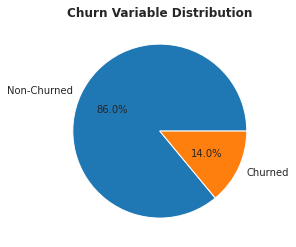

In [28]:
target.isChurned.value_counts().plot(kind="pie",autopct="%.1f%%",labels=["Non-Churned","Churned"])
plt.ylabel("")
plt.title("Churn Variable Distribution",fontweight="bold")
plt.show()

# 　Feature engineering特徵工程

In [29]:
household_per_campaign = dfs["campaign_table"].groupby("CAMPAIGN")["household_key"].apply(list)
total_campaigns = len(dfs["campaign_table"].CAMPAIGN.unique())
df_camp = pd.DataFrame(np.full((total_households,total_campaigns),0),columns=["Camp_"+str(i) for i in range(1,total_campaigns+1)],
                                                                                                           index=range(1,total_households+1))
for camp in household_per_campaign.index:
    df_camp.loc[household_per_campaign[camp],"Camp_"+str(camp)] = 1

df_camp["household_key"] = df_camp.index

In [30]:
temp = dfs["campaign_table"].household_key.value_counts().sort_index()
no_of_received_campaigns = pd.DataFrame(list(zip(temp.index,temp.values.astype(int))),columns=["household_key","no_of_received_campaigns"])

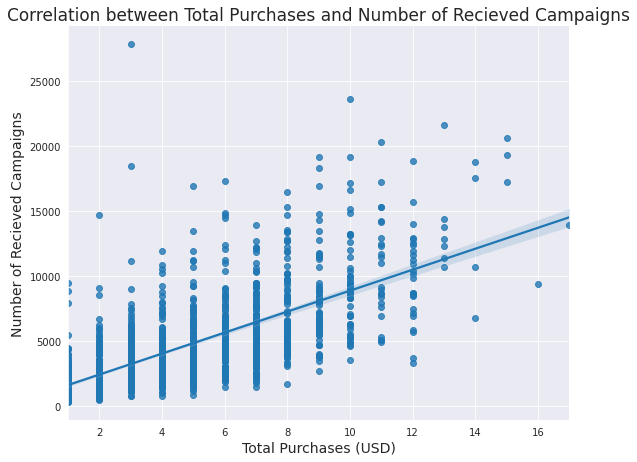

In [31]:
# plt.figure(figsize=(14,4))
no_of_received_campaigns_vs_sumsales = pd.merge(no_of_received_campaigns,purc_per_cust,on="household_key")
sns.lmplot(x="no_of_received_campaigns",y="Total Purchase (USD)",data=no_of_received_campaigns_vs_sumsales,
                                                                                                          size=6, aspect=1.3)
plt.title('Correlation between Total Purchases and Number of Recieved Campaigns', fontsize=17)
#總購買量與收到的廣告數量之間的相關性
plt.xlabel('Total Purchases (USD)', fontsize=14)
plt.ylabel('Number of Recieved Campaigns', fontsize=14)
plt.show()

In [32]:
no_of_received_campaigns_vs_sumsales.drop("household_key",axis=1).corr()

,no_of_received_campaigns,Total Purchase (USD)
no_of_received_campaigns,1.000000,0.704409
Total Purchase (USD),0.704409,1.000000


In [33]:
temp = dfs["coupon_redempt"].groupby("household_key")["CAMPAIGN"].apply(list)
rede_camp_history_per_household = pd.DataFrame(list(zip(temp.index,temp.values)),columns=["household_key","redeemed_CAMPAIGN_list"])

In [34]:
temp = dfs["coupon_redempt"].household_key.value_counts().sort_index()
no_of_rede_per_household = pd.DataFrame(list(zip(temp.index,temp.values.astype(int))),columns=["household_key","no_of_redeems"])

In [35]:
camp_list = dfs["campaign_table"].groupby("household_key")["DESCRIPTION"].apply(list)
most_freq_type = pd.DataFrame(list(zip(camp_list.index,[pd.Series(i).value_counts().idxmax() for i in camp_list])),columns=["household_key","most_freq_camp_type"])

In [36]:
store_per_house = dfs["transaction_data"].groupby("household_key")["STORE_ID"].apply(list).apply(np.unique)

churn_houses = set(target.household_key[target.isChurned == True].sort_values().values) & set(dfs["hh_demographic"].household_key.unique())
churn_stores = []
for i in churn_houses:
  churn_stores.extend(store_per_house[i])

churn_stores = pd.Series(churn_stores).value_counts()/len(churn_houses)

df_store = dfs["transaction_data"].groupby(["STORE_ID","household_key"]).count()["BASKET_ID"].unstack("STORE_ID")
df_store.replace(np.nan,0,inplace=True)
df_store[df_store>0] = 1
#select the top stores with high number of churners
df_store = df_store.loc[:,churn_stores.index[:20]]
df_store.columns=["Store_"+str(i) for i in df_store.columns]

In [37]:
purc_per_cust = dfs["transaction_data"].groupby("household_key").sum()["SALES_VALUE"].sort_values(ascending=False)
purc_per_cust = pd.DataFrame(list(zip(purc_per_cust.index,purc_per_cust)),columns=["household_key","Total Purchase (USD)"])

# 整合前面的分析數據

In [38]:
data = pd.merge(dfs["hh_demographic"],df_camp,on="household_key",how="left")
data = pd.merge(data,no_of_received_campaigns,on="household_key",how="left")
data = pd.merge(data,df_store,on="household_key",how="left")
data = pd.merge(data,no_of_rede_per_household,on="household_key",how="left")
data = pd.merge(data,most_freq_type,on="household_key",how="left")
data = pd.merge(data,purc_per_cust,on="household_key",how="left")
data = pd.merge(data,target,on="household_key",how="left")

data.shape

(801, 63)

In [39]:
data.head()

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key,Camp_1,Camp_2,...,Store_424,Store_402,Store_375,Store_292,Store_433,Store_367,no_of_redeems,most_freq_camp_type,Total Purchase (USD),isChurned
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,TypeB,4330.16,False
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,TypeB,3400.05,False
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,TypeB,5534.97,False
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,21.0,TypeB,13190.92,False
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,TypeB,1512.02,True


In [40]:
data.no_of_received_campaigns.replace(np.nan,0,inplace=True)
data.no_of_received_campaigns = data.no_of_received_campaigns.astype(int)
data.no_of_redeems.replace(np.nan,0,inplace=True)

In [41]:
data.KID_CATEGORY_DESC.replace(["None/Unknown","3+"],[0,3],inplace=True)
data.KID_CATEGORY_DESC = data.KID_CATEGORY_DESC.astype(int)
data.HOUSEHOLD_SIZE_DESC.replace("5+",5,inplace=True)
data.HOUSEHOLD_SIZE_DESC = data.HOUSEHOLD_SIZE_DESC.astype(int)
data["Total Purchase (USD)"] = data["Total Purchase (USD)"].astype(int)

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 801 entries, 0 to 800
Data columns (total 63 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   AGE_DESC                  801 non-null    object 
 1   MARITAL_STATUS_CODE       801 non-null    object 
 2   INCOME_DESC               801 non-null    object 
 3   HOMEOWNER_DESC            801 non-null    object 
 4   HH_COMP_DESC              801 non-null    object 
 5   HOUSEHOLD_SIZE_DESC       801 non-null    int64  
 6   KID_CATEGORY_DESC         801 non-null    int64  
 7   household_key             801 non-null    int64  
 8   Camp_1                    801 non-null    int64  
 9   Camp_2                    801 non-null    int64  
 10  Camp_3                    801 non-null    int64  
 11  Camp_4                    801 non-null    int64  
 12  Camp_5                    801 non-null    int64  
 13  Camp_6                    801 non-null    int64  
 14  Camp_7    

In [43]:
data.dtypes.value_counts()

int64      35
float64    21
object      6
bool        1
dtype: int64

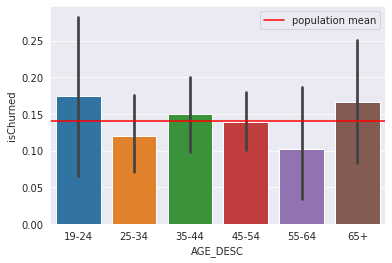

In [44]:
ax = sns.barplot(x="AGE_DESC",y="isChurned",data=data,order=["19-24","25-34","35-44","45-54","55-64","65+"])
ax.axhline(y=data.isChurned.sum()/len(data),c="red",label="population mean")
ax.legend()
plt.show()

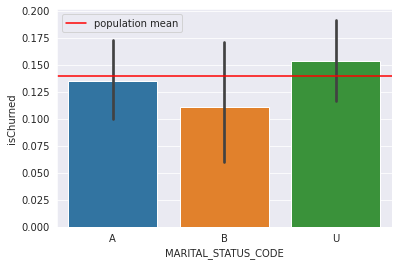

In [45]:
ax = sns.barplot(x="MARITAL_STATUS_CODE",y="isChurned",data=data,order=["A","B","U"])
ax.axhline(y=data.isChurned.sum()/len(data),c="red",label="population mean")
ax.legend()
plt.show()

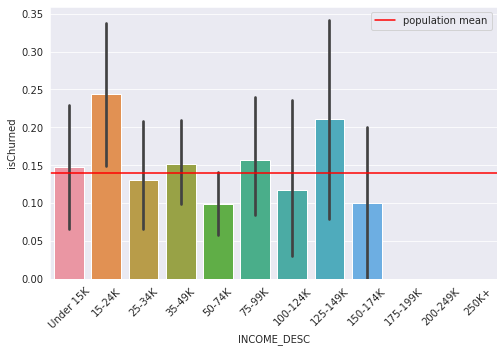

In [46]:
fig = plt.figure(figsize=(8,5))
ax = sns.barplot(x="INCOME_DESC",y="isChurned",data=data,
                 order=["Under 15K","15-24K","25-34K","35-49K","50-74K","75-99K","100-124K","125-149K","150-174K","175-199K","200-249K","250K+"])
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
ax.axhline(y=data.isChurned.sum()/len(data),c="red",label="population mean")
ax.legend()
plt.show()

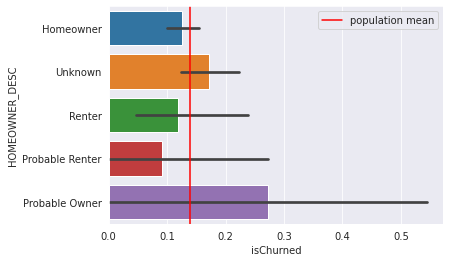

In [47]:
ax = sns.barplot(y="HOMEOWNER_DESC",x="isChurned",data=data,orient="h")
ax.axvline(x=data.isChurned.sum()/len(data),c="red",label="population mean")
ax.legend()
plt.show()

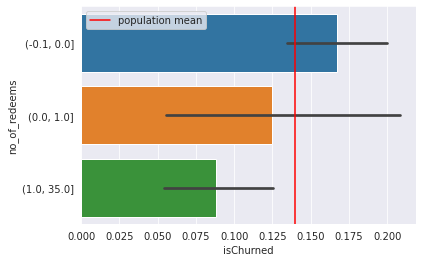

In [48]:
ax = sns.barplot(y=pd.cut(data.no_of_redeems,bins=[-0.1,0,1,35],duplicates="drop"),x="isChurned",data=data,orient="h")
ax.axvline(x=data.isChurned.sum()/len(data),c="red",label="population mean")
ax.legend()
plt.show()

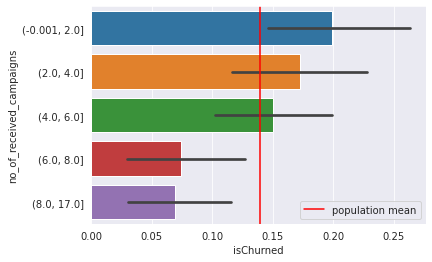

In [49]:
ax = sns.barplot(y=pd.qcut(data.no_of_received_campaigns,5,duplicates="drop"),x="isChurned",data=data,orient="h")
ax.axvline(x=data.isChurned.sum()/len(data),c="red",label="population mean")
ax.legend()
plt.show()

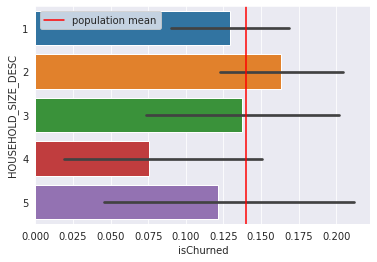

In [50]:
ax = sns.barplot(y="HOUSEHOLD_SIZE_DESC",x="isChurned",data=data,orient="h")
ax.axvline(x=data.isChurned.sum()/len(data),c="red",label="population mean")
ax.legend()
plt.show()

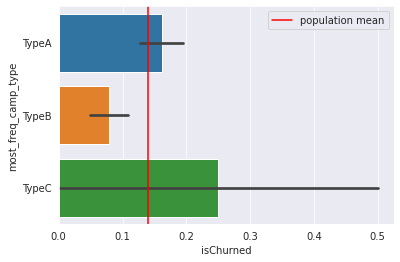

In [51]:
ax = sns.barplot(y="most_freq_camp_type",x="isChurned",data=data,orient="h",order=['TypeA','TypeB','TypeC'])
ax.axvline(x=data.isChurned.sum()/len(data),c="red",label="population mean")
ax.legend()
plt.show()

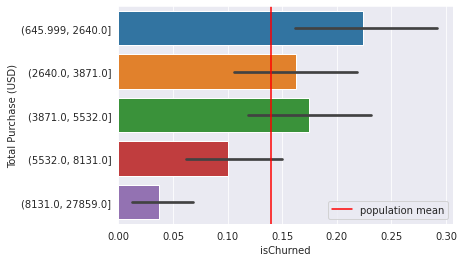

In [52]:
ax = sns.barplot(y=pd.qcut(data["Total Purchase (USD)"],5,duplicates="drop"),x="isChurned",data=data,orient="h")
ax.axvline(x=data.isChurned.sum()/len(data),c="red",label="population mean")
ax.legend()
plt.show()

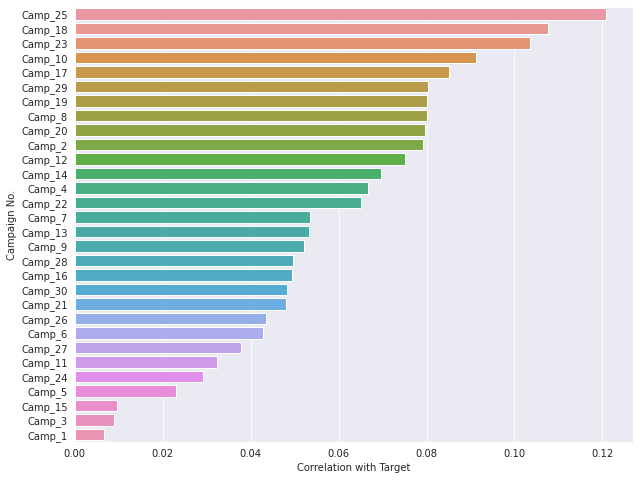

In [53]:
corrs = abs(data[["Camp_"+str(i) if i<31 else "isChurned" for i in range(1,32)]].corr()["isChurned"])
corrs.drop("isChurned",inplace=True)
corrs = pd.DataFrame(list(zip(corrs.index,corrs)),columns=["Campaign No.","Correlation with Target"]).sort_values(by="Correlation with Target",ascending=False)
fig_store = plt.figure(figsize=(10,8))
sns.barplot(y="Campaign No.",x="Correlation with Target",data = corrs,orient="h")
plt.show()

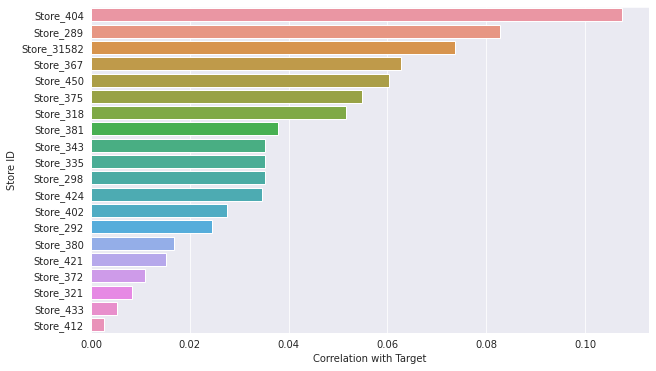

In [54]:
cols =list(df_store.columns)
cols.extend(["isChurned"])
corrs = abs(data[cols].corr()["isChurned"])
corrs.drop("isChurned",inplace=True)
corrs = pd.DataFrame(list(zip(corrs.index,corrs)),columns=["Store ID","Correlation with Target"]).sort_values(by="Correlation with Target",ascending=False)
fig_store = plt.figure(figsize=(10,6))
sns.barplot(y="Store ID",x="Correlation with Target",data = corrs,orient="h")
plt.show()

# ML模型訓練與測試

In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

#one hot encoding categorical data for modelling
encoded = pd.get_dummies(data[data.columns[data.dtypes==object]])
data_encoded = pd.concat([encoded, data[data.columns[data.dtypes != object]]],axis=1)

#Features (X) and the target (y)
X = data_encoded.drop("isChurned",axis=1)
y = data_encoded.isChurned

#lets start with the default hyperparameters and hold-out mechanism for train/test split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25)
#XGBoost
xgb_mdl = XGBClassifier().fit(X_train.values,y_train.values)
xgb_mdl

[10:47:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=2, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Train Data Classification Report:

              precision    recall  f1-score   support

       False       1.00      1.00      1.00       518
        True       1.00      1.00      1.00        82

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600

Test Data Classification Report:

              precision    recall  f1-score   support

       False       0.86      0.96      0.91       171
        True       0.40      0.13      0.20        30

    accuracy                           0.84       201
   macro avg       0.63      0.55      0.56       201
weighted avg       0.79      0.84      0.81       201



[Text(0.5, 15.0, 'predicted values'),
 Text(33.0, 0.5, 'real values'),
 Text(0.5, 1.0, 'Confusion Matrix')]

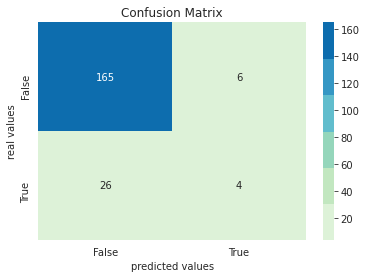

In [58]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, average_precision_score

#XGBoost
y_pred_train = xgb_mdl.predict(X_train.values)
y_pred = xgb_mdl.predict(X_test.values)

print("Train Data Classification Report:\n")
print(classification_report(y_train,y_pred_train))

print("Test Data Classification Report:\n")
print(classification_report(y_test,y_pred))
#generate a confusion matrix to visualise precision, recall, misclassification and false alarms
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), index = list(set(y)), columns = list(set(y)))

#visualise the confusion matrix in the heatmap form
plt.figure()
sns.heatmap(cm, annot = True, fmt="d",
            cmap=sns.color_palette("GnBu")).set(xlabel='predicted values', 
                                                ylabel='real values', 
                                                title = 'Confusion Matrix')

In [59]:
roc_auc_score(y_test,y_pred)
# average_precision_score(y_test,y_pred)

0.5491228070175439

In [60]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

In [61]:
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, RandomizedSearchCV

#handle class imbalance problem by undersampling (not used)
# no_churn_down_sampled = data_encoded[data_encoded.isChurned == False].sample(sum(data_encoded.isChurned))
# data_encoded_balanced = pd.concat([no_churn_down_sampled,data_encoded[data_encoded.isChurned]])
#shuffle the dataset to avoiding sampling biases
# data = data_encoded_balanced.sample(frac=1)

#shuffle the dataset to avoiding sampling biases
data = data_encoded.sample(frac=1)
X = data.drop("isChurned",axis=1)
y = data.isChurned
#generate an XGB classifier
mdl = XGBClassifier()

#parameter ranges
param_list = {
    'silent': [False],
    'max_depth': range(2,51),
    'learning_rate': [0.001, 0.01, 0.1, 0.15],
    'subsample': np.arange(0,1.1,.1),
    'colsample_bytree': np.arange(0,1.1,.1),
    'colsample_bylevel': np.arange(0,1.1,.1),
    'min_child_weight': [0.5, 0.7, 1.0, 2.0, 3.0],
    'gamma': [0, 0.25, 0.5, 0.75, 0.9, 1.0],
    'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0, 500.0, 1000.0],
    'n_estimators': [2, 5, 10, 20, 50, 100],
    'scale_pos_weight': [1, 1.5, 2, 6, 6.1, 6.3, 6.5, 8],
    'max_delta_step': [1, 2, 3, 5, 10]
}

kfold = 5
cv_strat = RepeatedStratifiedKFold(n_splits=kfold,n_repeats=10)

#Randomized Search
# cv = RandomizedSearchCV(mdl,param_list,cv=cv_strat,n_iter=100,verbose=1,scoring="roc_auc",n_jobs=-1).fit(X.values,y.values)
cv = RandomizedSearchCV(mdl,param_list,cv=cv_strat,n_iter=100,verbose=1,scoring="balanced_accuracy",n_jobs=-1).fit(X.values,y.values)
# cv = RandomizedSearchCV(mdl,param_list,cv=cv_strat,n_iter=100,verbose=1,scoring="average_precision",n_jobs=-1).fit(X.values,y.values)

#use the best estimator after the hyperparameter optimisation
mdl_best = cv.best_estimator_

Fitting 50 folds for each of 100 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 230 tasks      | elapsed:   58.6s
[Parallel(n_jobs=-1)]: Done 544 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 894 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 1426 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 2048 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 2698 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 3550 tasks      | elapsed: 22.8min
[Parallel(n_jobs=-1)]: Done 4426 tasks      | elapsed: 38.3min


[11:39:00] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:39:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed: 51.5min finished


In [62]:
cv.best_params_

{'subsample': 0.5,
 'silent': False,
 'scale_pos_weight': 6.3,
 'reg_lambda': 50.0,
 'n_estimators': 50,
 'min_child_weight': 0.5,
 'max_depth': 27,
 'max_delta_step': 3,
 'learning_rate': 0.01,
 'gamma': 1.0,
 'colsample_bytree': 1.0,
 'colsample_bylevel': 0.2}

In [63]:
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate

cv_strat = RepeatedStratifiedKFold(n_splits=kfold,n_repeats=20)
scores = cross_validate(mdl_best,X.values,y.values,cv=cv_strat,verbose=3,n_jobs=-1,return_train_score=True,
                        scoring={"roc_auc":"roc_auc",
                                 "recall":"recall",
                                 "precision":"precision",
                                 "accuracy":"accuracy",
                                 "balanced_accuracy":"balanced_accuracy",
                                 "average_precision":"average_precision"}) 
pd.DataFrame(pd.DataFrame(scores).mean(),columns=["Score"]).drop(["fit_time","score_time"])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.8min finished


,Score
test_roc_auc,0.634981
train_roc_auc,0.837361
test_recall,0.582925
train_recall,0.825514
test_precision,0.197453
train_precision,0.281477
test_accuracy,0.607738
train_accuracy,0.679731
test_balanced_accuracy,0.597396
train_balanced_accuracy,0.740767


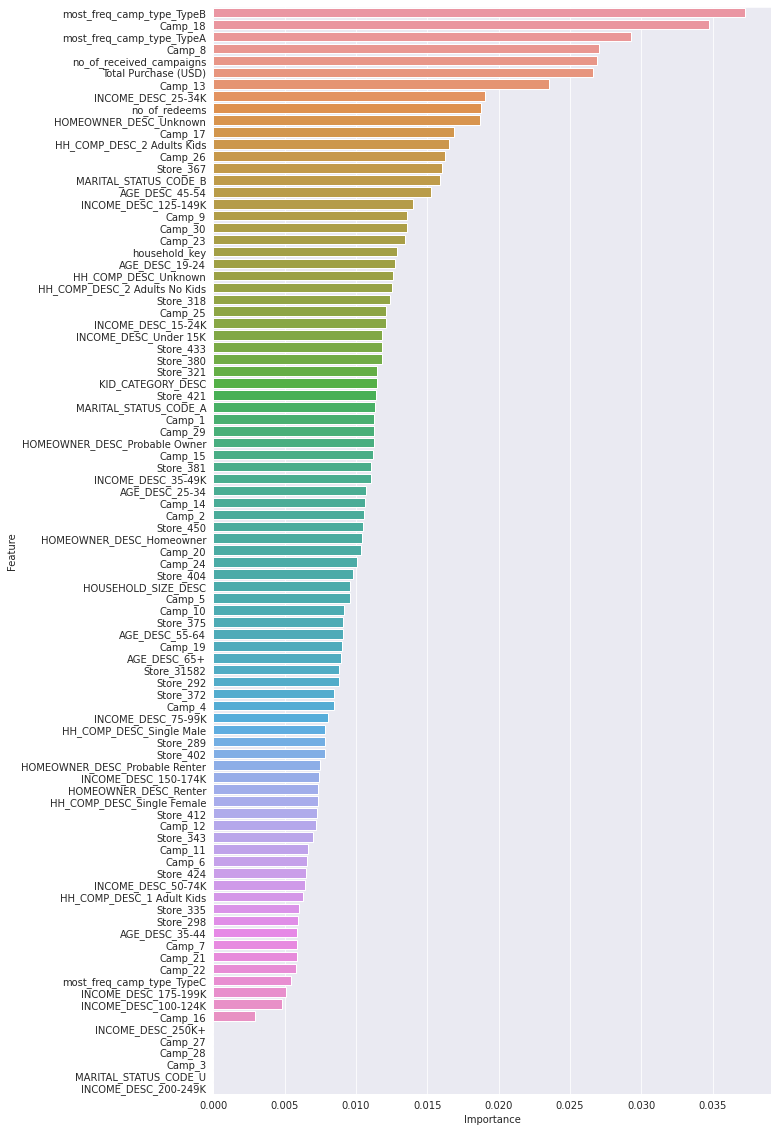

In [64]:
feat_imp = pd.DataFrame(list(zip(data.columns,mdl_best.feature_importances_)),columns=["Feature","Importance"]).sort_values(by="Importance",ascending=False)
fig_store = plt.figure(figsize=(10,20))
sns.barplot(y="Feature",x="Importance",data = feat_imp,orient="h")
plt.show()